<a href="https://colab.research.google.com/github/jorgeerodriguez/FinOps_AWS/blob/main/TimeSeries_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/GitHub/FinOps_AWS"
fnames = os.listdir(path)
for names in fnames:
  print(names)

FinOps copy.ipynb
Monthly_Cost_For_APR_2022.xlsx
Monthly_Cost_For_APR_2023.csv
Monthly_Cost_For_APR_2022.csv
Monthly_Cost_For_APR_2023.xlsx
Monthly_Cost_For_APR_2024.xlsx
Monthly_Cost_For_AUG_2022.csv
Monthly_Cost_For_APR_2024.csv
Monthly_Cost_For_AUG_2023.xlsx
Monthly_Cost_For_AUG_2022.xlsx
Monthly_Cost_For_AUG_2024.csv
Monthly_Cost_For_AUG_2023.csv
Monthly_Cost_For_DEC_2021.csv
Monthly_Cost_For_AUG_2024.xlsx
Monthly_Cost_For_DEC_2021.xlsx
Monthly_Cost_For_DEC_2022.csv
Monthly_Cost_For_DEC_2022.xlsx
Monthly_Cost_For_DEC_2023.csv
Monthly_Cost_For_DEC_2024.csv
Monthly_Cost_For_DEC_2023.xlsx
Monthly_Cost_For_FEB_2022.csv
Monthly_Cost_For_DEC_2024.xlsx
Monthly_Cost_For_FEB_2022.xlsx
Monthly_Cost_For_FEB_2024.csv
Monthly_Cost_For_FEB_2023.xlsx
Monthly_Cost_For_FEB_2023.csv
Monthly_Cost_For_FEB_2025.xlsx
Monthly_Cost_For_FEB_2024.xlsx
Monthly_Cost_For_JAN_2022.csv
Monthly_Cost_For_FEB_2025.csv
Monthly_Cost_For_JAN_2022.xlsx
Monthly_Cost_For_JAN_2023.csv
Monthly_Cost_For_JAN_2024.xlsx
Monthl

In [ ]:
!pip install common.utils

In [3]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from common.utils import load_data, mape
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [4]:
f = path + ("/combined.csv")
combined_df = pd.read_csv(f)
df_dl_p =combined_df.copy()
df_dl_p['Date_str'] = df_dl_p['Year'].apply(lambda x: str(x)) + "-" + df_dl_p['Month No'].apply(lambda x: str(x)) + "-01"
df_dl_p['Date'] = pd.to_datetime(df_dl_p['Date_str'])
df_dl_p.set_index('Date')
df_dl_p.index = pd.to_datetime(df_dl_p.index)
df_dl_p = df_dl_p.groupby(['Date']).agg(Cost=('Cost','sum'))

In [5]:
df_dl_p

,Cost
Date,
2021-10-01,3.794357e+05
2021-11-01,4.499119e+05
2021-12-01,4.646831e+05
2022-01-01,4.806844e+05
2022-02-01,4.958688e+05
2022-03-01,5.622309e+05
2022-04-01,6.468500e+05
2022-05-01,1.344622e+06
2022-06-01,7.066702e+05


In [6]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [7]:
ts_data_load = df_dl_p.copy()
ts_data_load.head()

,Cost
Date,
2021-10-01,"379,435.68"
2021-11-01,"449,911.87"
2021-12-01,"464,683.13"
2022-01-01,"480,684.44"
2022-02-01,"495,868.77"


In [8]:
valid_st_data_load = "2023-01-01 00:00:00" # Y-M-D
test_st_data_load = "2024-01-01 00:00:00"

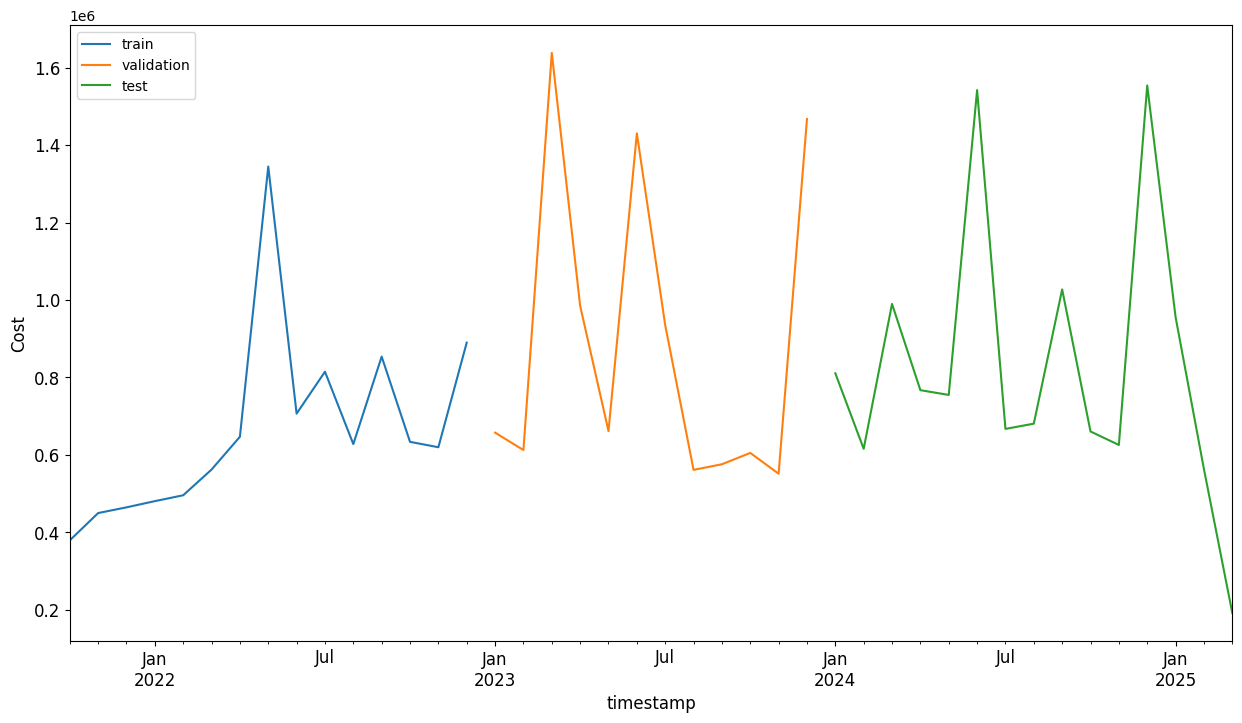

In [9]:
ts_data_load[ts_data_load.index < valid_st_data_load][["Cost"]].rename(columns={"Cost": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["Cost"]
    ].rename(columns={"Cost": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["Cost"]].rename(columns={"Cost": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.show()

In [10]:
T = 6
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][["Cost"]]

scaler = MinMaxScaler()
train["Cost"] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["Cost"].shift(T - t)
y_col = "y_t+1"
X_cols = ["Cost_t-5", "Cost_t-4", "Cost_t-3", "Cost_t-2", "Cost_t-1", "Cost_t"]
train_shifted.columns = ["Cost_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head()

,Cost_original,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t
Date,,,,,,,,
2022-03-01,0.19,0.28,0.00,0.07,0.09,0.10,0.12,0.19
2022-04-01,0.28,1.00,0.07,0.09,0.10,0.12,0.19,0.28
2022-05-01,1.00,0.34,0.09,0.10,0.12,0.19,0.28,1.00
2022-06-01,0.34,0.45,0.10,0.12,0.19,0.28,1.00,0.34
2022-07-01,0.45,0.26,0.12,0.19,0.28,1.00,0.34,0.45


In [11]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [12]:
T

6

In [13]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [14]:
y_train.shape

(9,)

In [15]:
y_train[:3]

array([0.28, 1.  , 0.34])

In [16]:
X_train.shape

(9, 6, 1)

In [17]:
train_shifted.head(3)

,Cost_original,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t
Date,,,,,,,,
2022-03-01,0.19,0.28,0.00,0.07,0.09,0.10,0.12,0.19
2022-04-01,0.28,1.00,0.07,0.09,0.10,0.12,0.19,0.28
2022-05-01,1.00,0.34,0.09,0.10,0.12,0.19,0.28,1.00


In [18]:
#look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    hours=T - 1
#)
#valid = ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)][
#    ["Cost"]
#]

valid = ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["Cost"]
    ]

valid["Cost"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    valid_shifted["Cost_t-" + str(T - t)] = valid_shifted["Cost"].shift(T - t)

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head()

,Cost,y+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t-0
Date,,,,,,,,
2023-06-01,1.09,0.58,0.29,0.24,1.30,0.63,0.29,1.09
2023-07-01,0.58,0.19,0.24,1.30,0.63,0.29,1.09,0.58
2023-08-01,0.19,0.20,1.30,0.63,0.29,1.09,0.58,0.19
2023-09-01,0.20,0.23,0.63,0.29,1.09,0.58,0.19,0.20
2023-10-01,0.23,0.18,0.29,1.09,0.58,0.19,0.20,0.23


In [19]:
y_valid = valid_shifted["y+1"].to_numpy()
X_valid = valid_shifted[["Cost_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [20]:
y_valid.shape

(6,)

In [21]:
y_valid[:3]

array([0.58, 0.19, 0.2 ])

In [22]:
X_valid.shape

(6, 6, 1)

In [23]:
X_valid[:3]

array([[[0.29],
        [0.24],
        [1.3 ],
        [0.63],
        [0.29],
        [1.09]],

       [[0.24],
        [1.3 ],
        [0.63],
        [0.29],
        [1.09],
        [0.58]],

       [[1.3 ],
        [0.63],
        [0.29],
        [1.09],
        [0.58],
        [0.19]]])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [40]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = (
    200
)

In [41]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [42]:
model.compile(optimizer="RMSprop", loss="mse")

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 5)                   │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [45]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2700 - val_loss: 0.3304
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2525 - val_loss: 0.3171
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2406 - val_loss: 0.3066
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2310 - val_loss: 0.2976
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2229 - val_loss: 0.2896
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2157 - val_loss: 0.2824
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2092 - val_loss: 0.2758
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2031 - val_loss: 0.2697
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1975 - val_loss: 0.2639
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1923 - val_loss: 0.2585
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1873 - val_loss: 0.2534
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1826 - 

In [46]:
look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)

test = ts_data_load.copy()[test_st_data_load:][["Cost"]]

test["Cost"] = scaler.transform(test)

test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["Cost"].shift(-1)
for t in range(1, T + 1):
    test_shifted["Cost_t-" + str(T - t)] = test_shifted["Cost"].shift(T - t)

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted["y_t+1"].to_numpy()
X_test = test_shifted[["Cost_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [47]:
test_shifted

,Cost,y_t+1,Cost_t-5,Cost_t-4,Cost_t-3,Cost_t-2,Cost_t-1,Cost_t-0
Date,,,,,,,,
2024-06-01,1.20,0.30,0.45,0.24,0.63,0.40,0.39,1.20
2024-07-01,0.30,0.31,0.24,0.63,0.40,0.39,1.20,0.30
2024-08-01,0.31,0.67,0.63,0.40,0.39,1.20,0.30,0.31
2024-09-01,0.67,0.29,0.40,0.39,1.20,0.30,0.31,0.67
2024-10-01,0.29,0.26,0.39,1.20,0.30,0.31,0.67,0.29
2024-11-01,0.26,1.22,1.20,0.30,0.31,0.67,0.29,0.26
2024-12-01,1.22,0.60,0.30,0.31,0.67,0.29,0.26,1.22
2025-01-01,0.60,0.19,0.31,0.67,0.29,0.26,1.22,0.60
2025-02-01,0.19,-0.19,0.67,0.29,0.26,1.22,0.60,0.19


In [48]:
y_test

array([ 0.3 ,  0.31,  0.67,  0.29,  0.26,  1.22,  0.6 ,  0.19, -0.19])

In [49]:
X_test.shape

(9, 6, 1)

In [50]:
ts_predictions = model.predict(X_test)
ts_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


array([[0.32],
       [0.34],
       [0.35],
       [0.35],
       [0.37],
       [0.39],
       [0.34],
       [0.33],
       [0.34]], dtype=float32)

In [51]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2024-06-01,t+1,"687,991.86","667,258.51"
1,2024-07-01,t+1,"705,340.64","680,725.63"
2,2024-08-01,t+1,"717,964.36","1,027,314.59"
3,2024-09-01,t+1,"714,975.12","660,593.27"
4,2024-10-01,t+1,"732,995.42","625,740.62"


In [52]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [53]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.4820590227204996

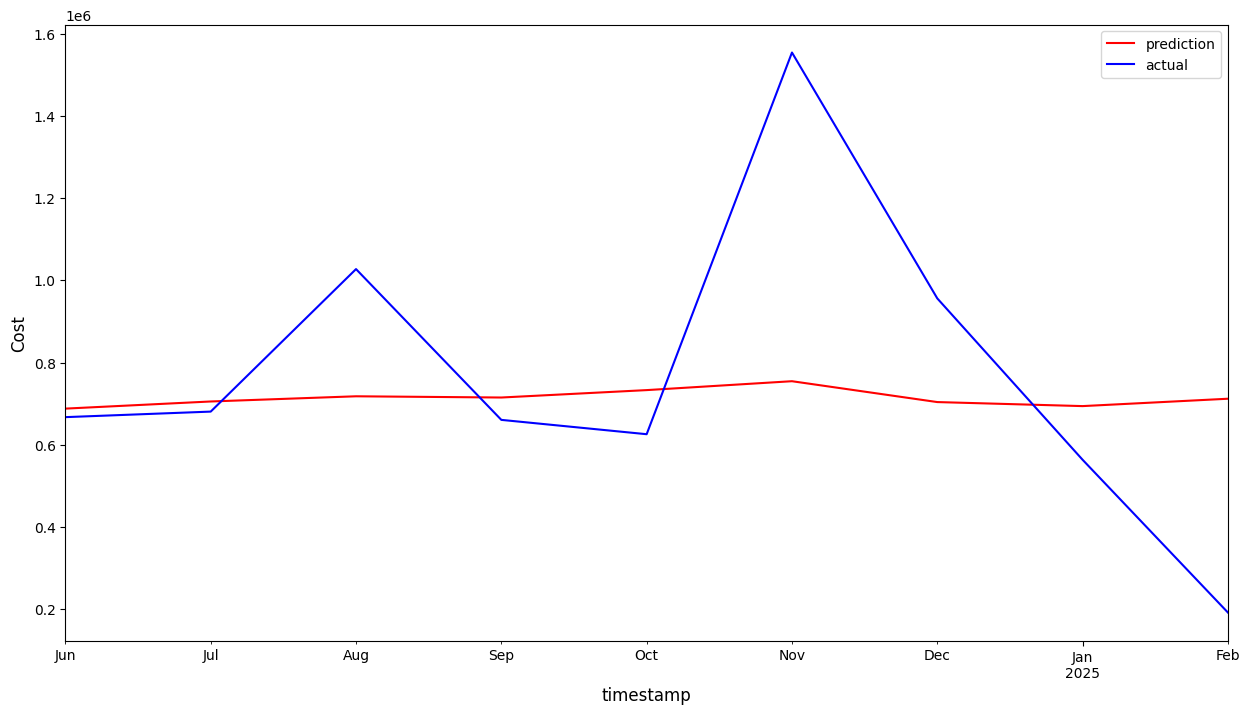

In [54]:
ev_ts_data[ev_ts_data.timestamp < "2026-01-01"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.show()

# Time Series Forcasting Using Deep Learning with PyTorch


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import yfinance as yf

In [5]:
#combined_df = pd.read_csv("combined.csv")
f = path + ("/combined.csv")
combined_df = pd.read_csv(f)
df_dl_p =combined_df.copy()
df_dl_p['Date_str'] = df_dl_p['Year'].apply(lambda x: str(x)) + "-" + df_dl_p['Month No'].apply(lambda x: str(x)) + "-01"
df_dl_p['Date'] = pd.to_datetime(df_dl_p['Date_str'])
df_dl_p.set_index('Date')
df_dl_p.index = pd.to_datetime(df_dl_p.index)
df_dl_p = df_dl_p.groupby(['Date']).agg(Cost=('Cost','sum'))

In [6]:
df_dl_p['Cost'].values

array([ 379435.67704427,  449911.87305182,  464683.13071651,
        480684.44135087,  495868.77473876,  562230.92500196,
        646850.02135427, 1344621.56086104,  706670.17392832,
        814895.03279678,  628009.11863612,  853861.65869291,
        633772.29234042,  619883.30722919,  889948.35091571,
        657555.14626922,  612616.3813554 , 1637977.72372277,
        984951.61981491,  661406.91502436, 1430313.2300025 ,
        935199.45099872,  561431.97407874,  575917.79240299,
        605203.31990461,  551499.40967322, 1467498.89985757,
        810804.83440277,  615822.80797646,  989912.92161552,
        767211.23927792,  754922.17987719, 1542013.75306699,
        667258.5063381 ,  680725.63096972, 1027314.58650558,
        660593.27243416,  625740.61553184, 1554001.93531605,
        956054.6327542 ,  563596.49421164,  192086.96314473])

In [7]:
cost = df_dl_p['Cost'].values
train , test = cost[:len(cost)-12], cost[len(cost)-12:]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.forecast(12)
for x in range(len(pred)):
  print('predicted=%f, expected=%f' % (pred[x], test[x]))





predicted=744439.261806, expected=767211.239278
predicted=1507136.107576, expected=754922.179877
predicted=764356.880814, expected=1542013.753067
predicted=851066.255591, expected=667258.506338
predicted=645065.257606, expected=680725.630970
predicted=822047.394280, expected=1027314.586506
predicted=567954.782784, expected=660593.272434
predicted=565053.720907, expected=625740.615532
predicted=809648.211496, expected=1554001.935316
predicted=574142.850433, expected=956054.632754
predicted=533527.462213, expected=563596.494212
predicted=1450149.210835, expected=192086.963145


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


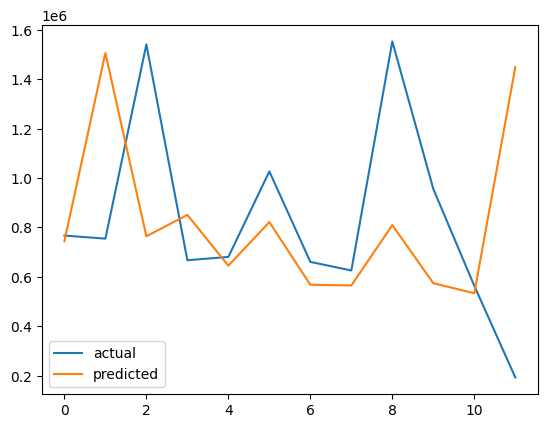

In [8]:
plt.plot(test, label='actual')
plt.plot(pred, label='predicted')
plt.legend()

In [9]:
import torch


In [10]:
def get_function(x1_val = 0, x2_val = 0, x3_val = 0, x4_val = 0):
  # variables
  x1 = torch.tensor(x1_val, requires_grad=True, dtype=torch.float32)
  x2 = torch.tensor(x2_val, requires_grad=True, dtype=torch.float32)
  x3 = torch.tensor(x3_val, requires_grad=True, dtype=torch.float32)
  x4 = torch.tensor(x4_val, requires_grad=True, dtype=torch.float32)

  # function
  p1 = x1.pow(3)
  m1 = p1 * x2
  m2 = x3 * x4
  f = m1 + m2
  vars = {'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4}
  return f, vars


In [11]:
if __name__ == '__main__':
  f, vars = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
  print(f.item())

47.0


In [12]:
# pip install torchviz

In [14]:
from torchviz import make_dot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



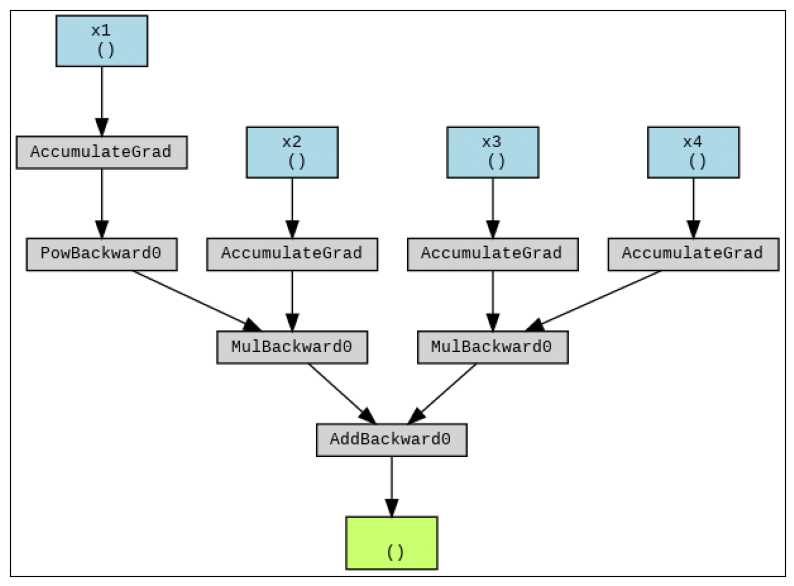

In [17]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
make_dot(f, params=params).render("function", format="png")
img = mpimg.imread('function.png')
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(img)
plt.show()


In [19]:
from torch.autograd import grad


In [27]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
df_dx1 = grad(f, params['x1'])
#df_dx2 = grad(f, params['x2'])
print(df_dx1)
#print(df_dx2)


(tensor(48.),)


In [31]:
f, params = get_function(x1_val = 2, x2_val = 4, x3_val = 3, x4_val = 5)
df_dx = grad(outputs=f, inputs=params.values())
print(df_dx)



(tensor(48.), tensor(8.), tensor(5.), tensor(3.))


In [32]:
import torch

In [33]:
x = torch.tensor(data=[1, 2, 3])
print(x)


tensor([1, 2, 3])
